In [1]:
from netCDF4 import Dataset
import os, sys
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
import pandas as pd
import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [2]:
path = '../products/'
files_ncdf = sorted(("{}{}".format(path,fn) for fn in os.listdir('../products') if fn.endswith('.ncdf')))

In [3]:
rootgrp = Dataset(files_ncdf[0], "r", format="NETCDF4") #Importa el dataset

In [4]:
rootgrp

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    Conventions: CF-1.7
    institution: KNMI
    source: Sentinel 5 precursor, TROPOMI, space-borne remote sensing, L2
    history: 2020-02-13 19:20:27 f_s5pops tropnll2dp /mnt/data1/storage_nrt/cache_nrt/WORKING-617411128/JobOrder.617410749.xml
    summary: TROPOMI/S5P Aerosol Index 1-Orbit L2 Swath 7x3.5km
    tracking_id: 4584da37-6e06-4744-9ed8-fcd5f0e6aaf0
    id: S5P_NRTI_L2__AER_AI_20200213T183253_20200213T183753_12107_01_010302_20200213T191550
    time_reference: 2020-02-13T00:00:00Z
    time_reference_days_since_1950: 25610
    time_reference_julian_day: 2458892.5
    time_reference_seconds_since_1970: 1581552000
    time_coverage_start: 2020-02-13T18:32:47Z
    time_coverage_end: 2020-02-13T18:37:59Z
    time_coverage_duration: PT312.473S
    time_coverage_resolution: PT0.840S
    orbit: 12107
    references: http://www.tropomi.eu/data-products/aerosol-index
    processor_version: 1.3.2
   

In [5]:
 # ***** Se extraen las variables de interes del archivo .ncdf para luego procesar ******#
Time = {}
Time["start"] = rootgrp.time_coverage_start 
Time["end"] = rootgrp.time_coverage_end
Time["create"] = rootgrp.date_created

geospatial = {}
geospatial["lat_min"] = rootgrp.geospatial_lat_min
geospatial["lat_max"] = rootgrp.geospatial_lat_max
geospatial["lon_min"] = rootgrp.geospatial_lon_min
geospatial["lon_max"] = rootgrp.geospatial_lon_max

AERO_340_380_precision = rootgrp.groups['PRODUCT'].variables['aerosol_index_340_380_precision'][:].data[0]
AERO_340_380 = rootgrp.groups['PRODUCT'].variables['aerosol_index_340_380'][:].data[0]
AERO_354_388_precision = rootgrp.groups['PRODUCT'].variables['aerosol_index_354_388_precision'][:].data[0]
AERO_354_388 = rootgrp.groups['PRODUCT'].variables['aerosol_index_354_388'][:].data[0]

latitude  = rootgrp.groups['PRODUCT'].variables['latitude'][:].data[0]
longitude = rootgrp.groups['PRODUCT'].variables['longitude'][:].data[0]

# **************************************************************************************  #


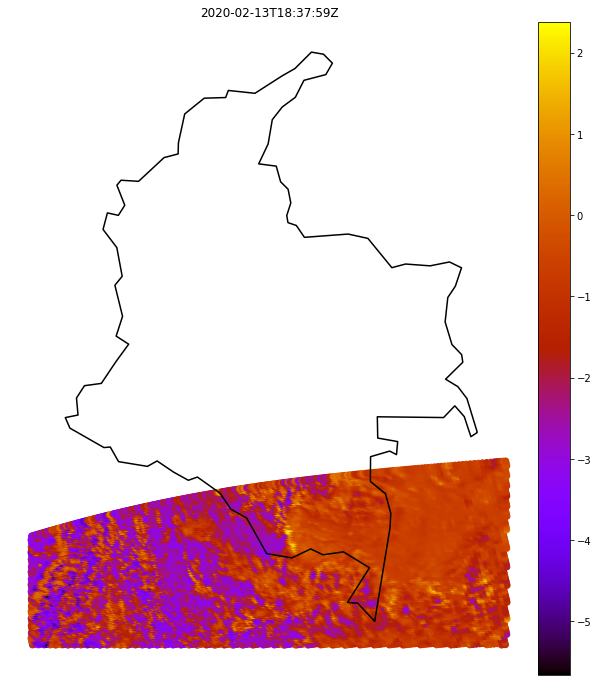

In [6]:
    
   
    

#  ***********   Se estructura la data para poder graficar con geopandas    ************  #
df = pd.DataFrame(
{'Data' : np.hstack(AERO_340_380),
 'Presicion' : np.hstack(AERO_340_380_precision),
 'Latitude': np.hstack(latitude),
 'Longitude': np.hstack(longitude)
})


gdf = gpd.GeoDataFrame( df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude)) #Objeto Geopandas con datos de sentinel
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')) #Objeto geopandas con pligono Mapamundi

# ---  Ignorar latitudes y longitudes distintas a colombia
gdf = gdf[gdf.Latitude > -5]
gdf = gdf[gdf.Latitude < 12]
gdf = gdf[gdf.Longitude > -80]
gdf = gdf[gdf.Longitude < -66]
# --------------------------------------------------------


fig, axx = plt.subplots(1) #Inicializa objeto de imagen
plt.close(fig)

ax = world[world.name == "Colombia"].boundary.plot(
    color='black', edgecolor='black', figsize= (15,12),zorder=2) #Base con dimenciones "Latitud longitud" de colombia

divider = make_axes_locatable(ax) 
cax = divider.append_axes("right", size="6%", pad=0.1) #Barra de colores para datos Sentinel 5

axx = gdf.plot(column='Data', ax=ax,  legend=True, cax=cax,zorder=1,cmap='gnuplot') #Se grafica 'Data' que contiene datos Sentinel
axx.set_axis_off()

axx.set_title(rootgrp.time_coverage_end )
axx.tick_params(labelsize=20)
